### Predicting ATM Fraud

In this notebook you will learn how to build a classification model with Spark machine learning API (SparkML).

The notebook implements the following steps:
- Perform data understanding and preparation tasks
- Build a model with SparkML API
- Evaluate and test the model

### Use Case

The analytics use case implemented in this notebook is detecting Mortgage Default. While it's a simple use case, it implements all steps from the CRISP-DM methodolody, which is the recommended best practice in data science.
![CRISP-DM](https://raw.githubusercontent.com/rosswlewis/ATM_Fraud/master/assets/crisp_dm.png)

Use case implementation starts with defining the business problem and identifying the data that can be used to solve the problem. For Mortgage Default, we use historical transaction data. We also know which transactions are fraud, which is the critical information for building predictive models. In the next step, we use visual APIs for data understanding and complete some data preparation tasks. In a typical analytics project data preparation will include more steps (for example, formatting data or deriving new variables). 

Once the data is ready, we can build a predictive model. In our example we show implementaiton of SparkML *Logistic Regression* and *Random Forrest* classification models. Classification is a statistical technique which assigns a "class" to each customer record (for our use case "fraud" or "not fraud"). Classification models use historical data to come up with the logic to predict "class", this process is called model training. After the model is created, it's usually evaluated using another data set. 

### Step 1: Load the Data

In [32]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-210be2d3-af5e-43b6-9d74-0427ae8ae81a',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': '9FthwkkdExB6wrCH1HafvISYEZEeKAKEKpWfPg9TV2hM'
}

configuration_name = 'os_b6ce1d66a23747c685affa13595b2acb_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
historicalMortgageData = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load(cos.url('Mortgage_Data.csv', 'pyrlabtest-donotdelete-pr-ecn1gj2kpu5dli'))
historicalMortgageData.take(5)


[Row(ID='100522', Income=43982, AppliedOnline='YES', Residence='Owner Occupier', YearCurrentAddress=13, YearsCurrentEmployer=11, NumberOfCards=2, CCDebt=1055, Loans=0, LoanAmount=9405, SalePrice=500000, Location=110, MortgageDefault='NO'),
 Row(ID='101756', Income=59944, AppliedOnline='YES', Residence='Owner Occupier', YearCurrentAddress=20, YearsCurrentEmployer=11, NumberOfCards=2, CCDebt=3894, Loans=0, LoanAmount=9880, SalePrice=750000, Location=110, MortgageDefault='NO'),
 Row(ID='101354', Income=57718, AppliedOnline='YES', Residence='Owner Occupier', YearCurrentAddress=25, YearsCurrentEmployer=16, NumberOfCards=2, CCDebt=1555, Loans=1, LoanAmount=6285, SalePrice=155000, Location=130, MortgageDefault='YES'),
 Row(ID='100512', Income=45621, AppliedOnline='YES', Residence='Owner Occupier', YearCurrentAddress=1, YearsCurrentEmployer=19, NumberOfCards=1, CCDebt=1878, Loans=0, LoanAmount=9260, SalePrice=195000, Location=100, MortgageDefault='YES'),
 Row(ID='100537', Income=45081, Applied

### Step 2: Data Understanding

In [33]:
# The show funtion provides a better view of the data than the take() method
historicalMortgageData.show()

+------+------+-------------+---------------+------------------+--------------------+-------------+------+-----+----------+---------+--------+---------------+
|    ID|Income|AppliedOnline|      Residence|YearCurrentAddress|YearsCurrentEmployer|NumberOfCards|CCDebt|Loans|LoanAmount|SalePrice|Location|MortgageDefault|
+------+------+-------------+---------------+------------------+--------------------+-------------+------+-----+----------+---------+--------+---------------+
|100522| 43982|          YES| Owner Occupier|                13|                  11|            2|  1055|    0|      9405|   500000|     110|             NO|
|101756| 59944|          YES| Owner Occupier|                20|                  11|            2|  3894|    0|      9880|   750000|     110|             NO|
|101354| 57718|          YES| Owner Occupier|                25|                  16|            2|  1555|    1|      6285|   155000|     130|            YES|
|100512| 45621|          YES| Owner Occupier| 

In [34]:
# Next, we review the data types
historicalMortgageData.dtypes

[('ID', 'string'),
 ('Income', 'int'),
 ('AppliedOnline', 'string'),
 ('Residence', 'string'),
 ('YearCurrentAddress', 'int'),
 ('YearsCurrentEmployer', 'int'),
 ('NumberOfCards', 'int'),
 ('CCDebt', 'int'),
 ('Loans', 'int'),
 ('LoanAmount', 'int'),
 ('SalePrice', 'int'),
 ('Location', 'int'),
 ('MortgageDefault', 'string')]

If you used the generated code to read in data, then the data type for all variables is *string*. Some variables, for example, the FRAUD flag, should be an interger. We can convert data types, but if you have many columns, it may be easier to add the *inferSchema* parameter on data load.

The modified code to read in data will look like this: 

**historicalATMFraud = spark.read\ <BR>
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\ <BR>
  .option('header', 'true')\ <BR>
  .option('inferSchema', 'true')\ <BR>
  .load(cos.url('ATM_Data.csv', 'pyrlabtest-donotdelete-pr-ecn1gj2kpu5dli'))**
  
If you rerun the code to read in data, now **MODEL** and **Time of Day** columns have data type of *int*

In [35]:
# Display summary statistics
historicalMortgageData.describe().show()

+-------+------------------+-----------------+-------------+--------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+---------------+
|summary|                ID|           Income|AppliedOnline|           Residence|YearCurrentAddress|YearsCurrentEmployer|     NumberOfCards|            CCDebt|              Loans|        LoanAmount|         SalePrice|          Location|MortgageDefault|
+-------+------------------+-----------------+-------------+--------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+---------------+
|  count|              1030|             1030|         1030|                1030|              1030|                1030|              1030|              1030|               1030|              1030|              1030|              1030|     

In [36]:
# Summary statistics may be difficult to read in the row format, so let's display it in the column format
historicalMortgageData.describe().show(vertical=True)

-RECORD 0------------------------------------
 summary              | count                
 ID                   | 1030                 
 Income               | 1030                 
 AppliedOnline        | 1030                 
 Residence            | 1030                 
 YearCurrentAddress   | 1030                 
 YearsCurrentEmployer | 1030                 
 NumberOfCards        | 1030                 
 CCDebt               | 1030                 
 Loans                | 1030                 
 LoanAmount           | 1030                 
 SalePrice            | 1030                 
 Location             | 1030                 
 MortgageDefault      | 1021                 
-RECORD 1------------------------------------
 summary              | mean                 
 ID                   | 100810.22837706511   
 Income               | 48523.30679611651    
 AppliedOnline        | null                 
 Residence            | null                 
 YearCurrentAddress   | 11.9640776

Since most variables are non-numeric, we will do additional data understanding later. But the first descriptive statistics, **count**, shows us that we may have some invalid values in several columns. We can confirm the row count by using the count() funtion.  

In [37]:
historicalMortgageData.count()

1030

The output of the describe() method showed us that the MortageDefault column has less records than other records. There are several ways to deal with missing values. Factors such as number of missing values and the importance of the field for modeling should be taken into consideration. 

Since we have only a few records with missing values, we will drop them. 

In [38]:
# Drop columns which we will not use for data understanding and modeling
historicalMortgageData = historicalMortgageData.drop("ID")
# Display the count of the data frame if we drop the records with missing values
historicalMortgageData.na.drop().count()

1021

In [39]:
# Since data frames are not mutable, we have to create a new object with null values removed
historicalMortgageData.count()

1030

In [15]:
historicalMortgageData=historicalMortgageData.na.drop()
# Check record count of the new data frame
historicalMortgageData.count()

1021

### Step 3: Understand the Data with Visualizations

Visualization is one of the most effective ways to understand data. There are several visualization APIs that can be used. In this sample notebook we will use *PixieDust*, which provides an interactive interface for visualizations. <BR>

PixieDust supports Spark data frames, while many other visualization APIs work only with Pandas data frames. <BR>

More information about PixieDust: https://github.com/ibm-cds-labs/pixiedust?cm_mc_uid=78151411419314871783930&cm_mc_sid_50200000=1487962969  <BR>


Using the interactive interface, check the number of loans that went into default. It's important that the dataset used for modeling is balanced. 



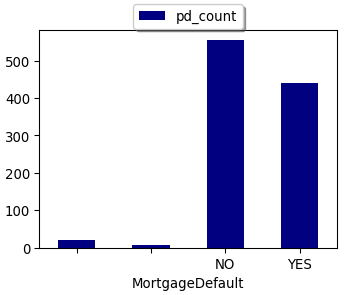

In [ ]:
# Run this line once in a notebook
#!pip install --upgrade pixiedust


from pixiedust.display import *
display(historicalMortgageData)

### Step 4: Build the Spark pipeline and the Random Forest models
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

We are not using all columns for modeling because we can tell that some of them are correlated just by description - *Region* and *City* (we kept *City*), and 
*Time* and *Time Band* (we kept *Time*)<BR>
As mentioned earlier, in a production implementation a data scientist will use statistical and other methods for feature selection. 

In [17]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler


# This code desribes the steps that should be applied to categorical data for modeling. First, we convert String values to an index, and then we encode them.
# The steps are recorded in teh "stages" object. The indexing/encoding is not applied until we run the Pipeline.fit() method.  
categoricalColumns = ["AppliedOnline", "Residence"]
stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="MortgageDefault", outputCol="label")
stages += [label_stringIdx]


In [18]:
# We also have one numeric column
numericCols = ["Income", "YearCurrentAddress","YearsCurrentEmployer","NumberOfCards","CCDebt","Loans","LoanAmount","SalePrice","Location"]

# The ML API requires that all features are passed in as a single Vector, which we are creating here
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [21]:
partialPipeline = Pipeline().setStages(stages)
# Running this code will apply the string indexing and encoding operations
pipelineModel = partialPipeline.fit(historicalMortgageData)
preppedDataDF = pipelineModel.transform(historicalMortgageData)

In [22]:
# You can review the data that will be used for modeling
display(preppedDataDF)

Income,AppliedOnline,Residence,YearCurrentAddress,YearsCurrentEmployer,NumberOfCards,CCDebt,Loans,LoanAmount,SalePrice,Location,MortgageDefault,AppliedOnlineIndex,AppliedOnlineclassVec,ResidenceIndex,ResidenceclassVec,label,features
59944,YES,Owner Occupier,20,11,2,3894,0,9880,750000,110,NO,0.0,"(1,[0],[1.0])",0.0,"(4,[0],[1.0])",0.0,"[1.0,1.0,0.0,0.0,0.0,59944.0,20.0,11.0,2.0,3894.0,0.0,9880.0,750000.0,110.0]"
44202,NO,Owner Occupier,1,23,2,2611,0,12915,162000,101,NO,1.0,"(1,[],[])",0.0,"(4,[0],[1.0])",0.0,"[0.0,1.0,0.0,0.0,0.0,44202.0,1.0,23.0,2.0,2611.0,0.0,12915.0,162000.0,101.0]"
45450,YES,Owner Occupier,15,24,1,4217,0,8040,270000,100,YES,0.0,"(1,[0],[1.0])",0.0,"(4,[0],[1.0])",1.0,"[1.0,1.0,0.0,0.0,0.0,45450.0,15.0,24.0,1.0,4217.0,0.0,8040.0,270000.0,100.0]"
45993,NO,Public Housing,6,7,2,311,0,8670,199000,100,NO,1.0,"(1,[],[])",2.0,"(4,[2],[1.0])",0.0,"[0.0,0.0,0.0,1.0,0.0,45993.0,6.0,7.0,2.0,311.0,0.0,8670.0,199000.0,100.0]"
43669,YES,Living with parents/guardian,18,10,1,2518,0,12500,325000,100,YES,0.0,"(1,[0],[1.0])",3.0,"(4,[3],[1.0])",1.0,"[1.0,0.0,0.0,0.0,1.0,43669.0,18.0,10.0,1.0,2518.0,0.0,12500.0,325000.0,100.0]"
50552,YES,Owner Occupier,5,23,1,466,0,6880,380000,110,YES,0.0,"(1,[0],[1.0])",0.0,"(4,[0],[1.0])",1.0,"[1.0,1.0,0.0,0.0,0.0,50552.0,5.0,23.0,1.0,466.0,0.0,6880.0,380000.0,110.0]"
43800,YES,Owner Occupier,0,4,2,725,0,7340,259000,100,NO,0.0,"(1,[0],[1.0])",0.0,"(4,[0],[1.0])",0.0,"[1.0,1.0,0.0,0.0,0.0,43800.0,0.0,4.0,2.0,725.0,0.0,7340.0,259000.0,100.0]"
43120,YES,Public Housing,4,10,1,801,1,6220,215000,100,YES,0.0,"(1,[0],[1.0])",2.0,"(4,[2],[1.0])",1.0,"[1.0,0.0,0.0,1.0,0.0,43120.0,4.0,10.0,1.0,801.0,1.0,6220.0,215000.0,100.0]"
43835,YES,Owner Occupier,3,1,2,1501,1,12220,144000,100,NO,0.0,"(1,[0],[1.0])",0.0,"(4,[0],[1.0])",0.0,"[1.0,1.0,0.0,0.0,0.0,43835.0,3.0,1.0,2.0,1501.0,1.0,12220.0,144000.0,100.0]"
45153,NO,Owner Occupier,2,13,2,804,1,8900,146000,130,YES,1.0,"(1,[],[])",0.0,"(4,[0],[1.0])",1.0,"[0.0,1.0,0.0,0.0,0.0,45153.0,2.0,13.0,2.0,804.0,1.0,8900.0,146000.0,130.0]"


In [26]:
### Split data into training and test sets. Set seed for reproducibility
(trainingData, testData) = preppedDataDF.randomSplit([0.8, 0.2], seed=100)
trainingData.cache()
testData.cache()

DataFrame[Income: int, AppliedOnline: string, Residence: string, YearCurrentAddress: int, YearsCurrentEmployer: int, NumberOfCards: int, CCDebt: int, Loans: int, LoanAmount: int, SalePrice: int, Location: int, MortgageDefault: string, AppliedOnlineIndex: double, AppliedOnlineclassVec: vector, ResidenceIndex: double, ResidenceclassVec: vector, label: double, features: vector]

In [27]:
# First, we'll build a logistic regression model

from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [28]:
# Make predictions on test data using the transform() method.
predictions = lrModel.transform(testData)
display(predictions)

label,rawPrediction,probability,prediction
0.0,"[1.62580993545241,1.4498623897709948,-0.37817600316339095,-2.6974963220600126]","[0.5033434904172162,0.42213504508493754,0.06784915158701793,0.006672312910828346]",0.0
0.0,"[1.9467462182453006,2.5005309969970875,-1.4053642501102832,-3.0419129651321044]","[0.3594987797171274,0.6254651178454042,0.012586191677504107,0.0024499107599642513]",1.0
0.0,"[1.9254298277285964,1.8050016306949035,-0.8040122284722311,-2.9264192299512684]","[0.5103055320291496,0.4524066446622972,0.033300338847972344,0.003987484460580934]",0.0
0.0,"[1.9254298277285964,1.8050016306949035,-0.8040122284722311,-2.9264192299512684]","[0.5103055320291496,0.4524066446622972,0.033300338847972344,0.003987484460580934]",0.0
0.0,"[1.6830726709847386,2.720755855648491,-1.7145018304662867,-2.6893266961669426]","[0.25848175135312107,0.729608640690521,0.008647329938188111,0.003262278018169887]",1.0
2.0,"[2.062077428192362,1.6296006541344343,-1.9145991811193208,-1.777078901207475]","[0.5920104019819363,0.38415550501400925,0.011098917669738563,0.01273517533431591]",0.0
1.0,"[1.371277366457712,2.1266885009419716,-1.2694748286557582,-2.2284910387439245]","[0.3098734255943521,0.6595613837697702,0.022096334045112177,0.00846885659076545]",1.0
0.0,"[2.451628861760601,2.0453124824205884,-1.9203240550836767,-2.576617289097512]","[0.5933745316784862,0.3952464159647738,0.0074922778549218584,0.0038867745018182622]",0.0
0.0,"[1.8459666036764264,1.4616416653261455,-0.11578728331639221,-3.1918209856861792]","[0.5470430155837761,0.3724871349114172,0.07692058695641563,0.003549262548391172]",0.0
1.0,"[2.3932921712936706,2.2113992960879303,-2.3061379688718824,-2.298553498509718]","[0.5399682173145248,0.45016645114084386,0.004913960033306646,0.004951371511324661]",0.0


In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model - the displayed evaluation is AUC ROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.5419172932330825

In [30]:
# Next, we will build a Random Forest model
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Train model with Training Data
rfModel = rf.fit(trainingData)

In [31]:
# Make predictions on test data using the Transformer.transform() method.
rf_predictions = rfModel.transform(testData)

# Evaluate model
rf_evaluator = BinaryClassificationEvaluator()
rf_evaluator.evaluate(rf_predictions)

0.9319548872180452

**We have finished building and testing a predictive model.** <BR>
As shown in the diagram of the CRISP-DM process, a data scientist will usually spend more time on refining the model (testing with different features and algorithms). After the desired accuracy is achieved, a model is deployed in production. We will cover deployment in another lab. 